# Use `Context` to pass data between tasks

## Introduction
In AiiDA workflows, both traditional `WorkChain`s, as well as the `WorkGraph`, the context (typically represented with
`ctx`), is an internal container that can hold data that shared between different tasks.
It's particularly very useful for complex workflows.

## Pass data to context

There are three ways to set data to ctx.

- Initialize the context data when creating the WorkGraph.
  ```python
  wg = WorkGraph(name="test_workgraph_ctx")
  # set ctx.x = Int(2), ctx.data.y = Int(3)
  wg.ctx = {"x": Int(2), "data.y": Int(3)}
  ```

- Set the task result to context when the task is done.
  ```python
  # define add task
  @task.calcfunction()
  def add(x, y):
    return x + y
  add1 = wg.add_task(add, "add1", x=2, y=3)
  # set result of add1 to ctx.sum
  wg.update_ctx({"sum": add1.outputs.result})
  ```

- Use the `update_ctx` task to set either the task result or a constant value to the ctx.

  ```python
  wg.add_task("workgraph.set_context", name="set_ctx1", key="sum", value=add1.outputs.result)
  ```


### Nested context keys
To organize the context data (e.g. group data), The keys may contain dots `.`, which will creating dictionary in the ctx. Here is an example, to group the results of all add tasks to `ctx.sum`:

```python
wg.update_ctx({"sum.add1": add1.outputs.result})
wg.update_ctx({"sum.add2": add2.outputs.result})
```
here, `ctx.sum` will be:
```python
{"add1": value1, "add2": value2}
```

## Use data from context
There are three ways to use data from context:

- One can use the `wg.ctx.x` syntax in the inputs of the task.
    
    ```python
    add1 = wg.add_task(add, "add1", x=wg.ctx.x, y=3)
    ```
    One can also use nested context keys, like `wg.ctx.sum.add1`.

- One can export the data from context to the graph builder outputs.
    
    ```python
    @task.graph_builder(outputs=[{"name": "result", "from": "ctx.sum"}])
    def my_while(n, limit):
        nt = WorkGraph("while_workgraph")
        add1 = wg.add_task(add, x=2, y=3)
        add2 = wg.add_task(add, x=2, y=3)
        wg.update_ctx({"sum.add1": add1.outputs.result})
        wg.update_ctx({"sum.add2": add2.outputs.result})
    ```

- One can use the `get_context` task to get the data from ctx. **This task will be shown in the GUI**

    ```python
    wg.add_task("workgraph.get_context", name="get_ctx1", key="sum.add1")
    ```

## First workflow

In [1]:
from aiida_workgraph import WorkGraph, task
from aiida import load_profile

load_profile()


@task.calcfunction()
def add(x, y):
    return x + y


wg = WorkGraph(name="test_workgraph_ctx")
# Set the context of the workgraph
wg.ctx = {"x": 2, "data.y": 3}
get_ctx1 = wg.add_task("workgraph.get_context", name="get_ctx1", key="x")
add1 = wg.add_task(add, "add1", x=get_ctx1.outputs.result, y=wg.ctx.data.y)
set_ctx1 = wg.add_task("workgraph.set_context", name="set_ctx1", key="x", value=add1.outputs.result)
wg.to_html()
# wg

As shown in the GUI, the `get_context` task and `to_context` tasks are shown in the GUI. However, the context variable using the `update_ctx` method or `wg.ctx.x` is not shown in the GUI.

### Submit the workflow and check the results

In [2]:
wg.submit(wait=True)
print("State of WorkGraph         : {}".format(wg.state))
print('Result of add1            : {}'.format(wg.tasks.add1.outputs.result.value))

07/07/2025 02:12:48 PM <224020> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.9.27 is not supported and will cause unexpected problems!
07/07/2025 02:12:48 PM <224020> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
07/07/2025 02:12:48 PM <224020> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.


WorkGraph process created, PK: 132
Process 132 finished with state: FINISHED
State of WorkGraph         : FINISHED
Result of add1            : uuid: 07a4a618-b8dc-44eb-9957-298994614600 (pk: 136) value: 5


Generate node graph from the AiiDA process,and we can see that the `multiply` task is executed.

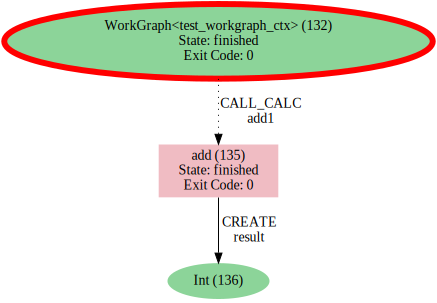

In [3]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

> **_NOTE:_**  If you pass data from one task to another task trough context, you may need to use `wait` to wait for the data to be ready. See [How to wait for another task](waiting_on.ipynb).